In [88]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson

In [89]:
# Load the dataset
file_path = 'data/data.csv'
data = pd.read_csv(file_path, delimiter=';')

# Initial model
model = smf.ols(formula='Right_answers ~ Age + Audio_prosody + Combined_channel + Face_video + Body_video + Positive_valence + Negative_valence + Dominant + Submissive', data=data).fit()

# Residuals analysis
residuals = model.resid
fitted = model.fittedvalues

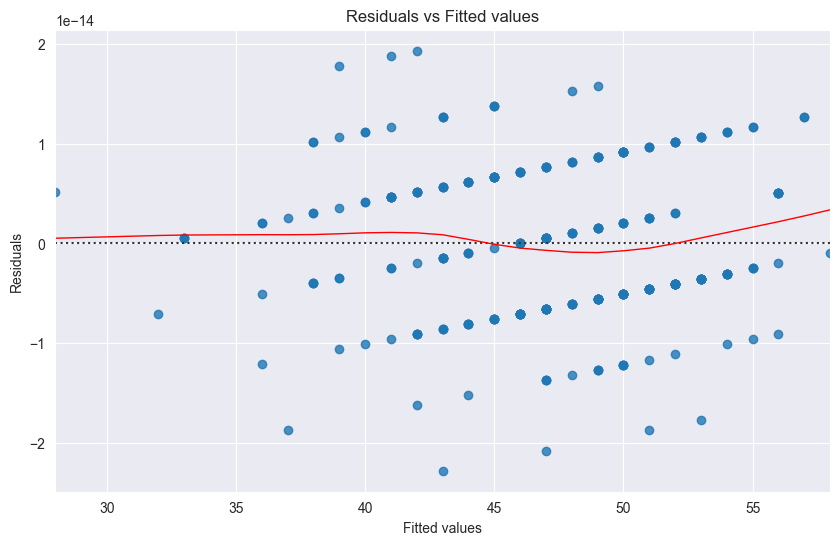

In [90]:
# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()

<Figure size 1000x600 with 0 Axes>

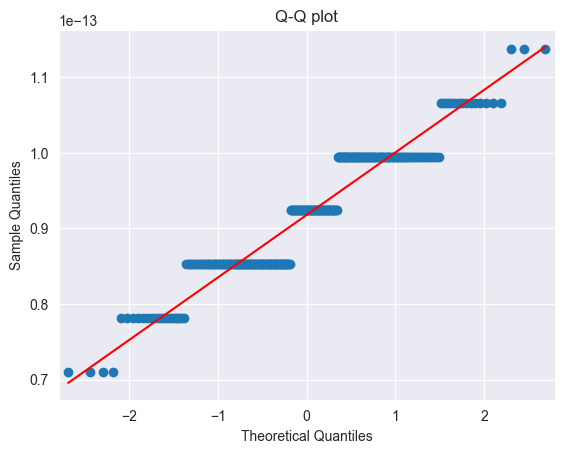

In [91]:
# Q-Q plot
plt.figure(figsize=(10, 6))
qqplot(residuals, line='s')
plt.title('Q-Q plot')
plt.show()

In [92]:
# Durbin-Watson test
dw_test = durbin_watson(residuals)

# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, model.model.exog)

# VIF for multicollinearity
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Variable'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Dropping highly correlated predictors step-by-step based on VIF and correlation matrix
predictors = data[['Age', 'Audio_prosody', 'Combined_channel', 'Face_video', 'Body_video', 'Positive_valence', 'Negative_valence', 'Dominant', 'Submissive']]
vif_data = calculate_vif(predictors)
print(vif_data)

# Iteratively remove the variable with the highest VIF until all VIFs are below 10
while vif_data['VIF'].max() > 10:
    highest_vif = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
    predictors = predictors.drop(columns=[highest_vif])
    vif_data = calculate_vif(predictors)
    print(vif_data)

# Reduced model with remaining predictors
formula = 'Right_answers ~ ' + ' + '.join(predictors.columns)
model_reduced = smf.ols(formula=formula, data=data).fit()

# Residuals analysis for the reduced model
residuals_reduced = model_reduced.resid
fitted_reduced = model_reduced.fittedvalues

           Variable        VIF
0               Age  10.901903
1     Audio_prosody        inf
2  Combined_channel        inf
3        Face_video        inf
4        Body_video        inf
5  Positive_valence        inf
6  Negative_valence        inf
7          Dominant        inf
8        Submissive        inf
           Variable         VIF
0               Age   10.901903
1  Combined_channel  105.638213
2        Face_video  113.324699
3        Body_video   91.971590
4  Positive_valence         inf
5  Negative_valence         inf
6          Dominant         inf
7        Submissive         inf
           Variable         VIF
0               Age   10.901903
1  Combined_channel  105.638213
2        Face_video  113.324699
3        Body_video   91.971590
4  Negative_valence  180.076187
5          Dominant  221.727422
6        Submissive  227.866947
           Variable         VIF
0               Age   10.871895
1  Combined_channel   70.756189
2        Face_video   85.100942
3        Body_vide

/Users/kanetoomer/miniconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/kanetoomer/miniconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


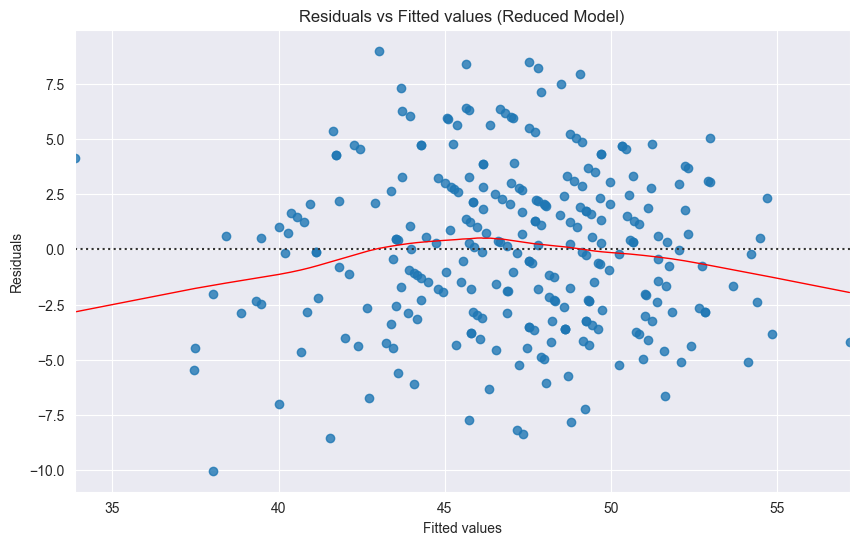

In [93]:
# Plot residuals vs fitted values for the reduced model
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_reduced, y=residuals_reduced, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values (Reduced Model)')
plt.show()

<Figure size 1000x600 with 0 Axes>

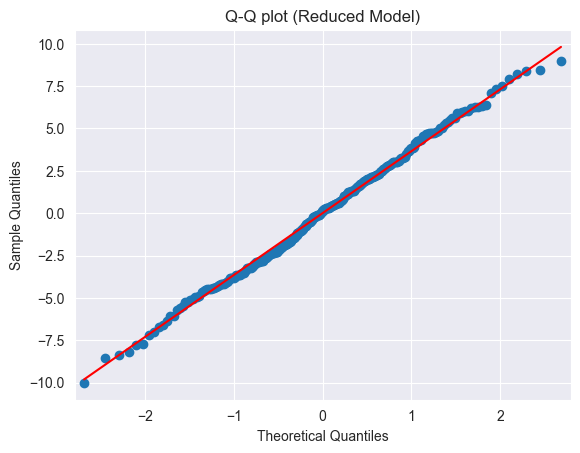

In [94]:
# Q-Q plot for the reduced model
plt.figure(figsize=(10, 6))
qqplot(residuals_reduced, line='s')
plt.title('Q-Q plot (Reduced Model)')
plt.show()

In [95]:
# Durbin-Watson test for the reduced model
dw_test_reduced = durbin_watson(residuals_reduced)

# Breusch-Pagan test for heteroscedasticity for the reduced model
bp_test_reduced = het_breuschpagan(residuals_reduced, model_reduced.model.exog)

# VIF for multicollinearity for the reduced model
vif_data_reduced = calculate_vif(data[predictors.columns])

# Non-Constant Variance Score (NCV) test for heteroscedasticity
ncv_test = het_white(residuals_reduced, model_reduced.model.exog)

# Cook's distance for outlier analysis
influence = model_reduced.get_influence()
cooks_d = influence.cooks_distance

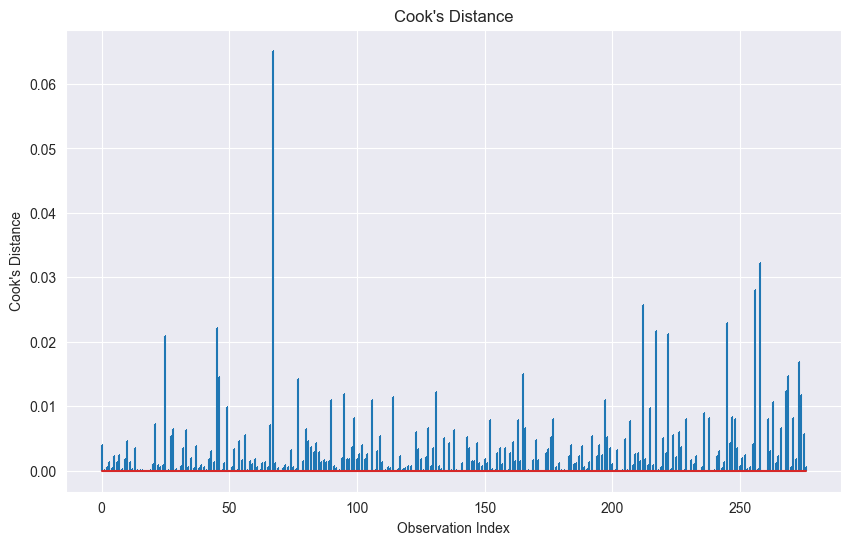

In [96]:
# Plot Cook's distance
plt.figure(figsize=(10, 6))
plt.stem(cooks_d[0], markerfmt=",")
plt.title('Cook\'s Distance')
plt.xlabel('Observation Index')
plt.ylabel('Cook\'s Distance')
plt.show()

In [97]:
# Threshold for identifying significant outliers (commonly 4/n)
n = len(data)
threshold = 4 / n
significant_outliers = cooks_d[0] > threshold

# Remove significant outliers from the dataset
cleaned_data = data[~significant_outliers]

# Fit a new linear regression model on the cleaned dataset
model_cleaned = smf.ols(formula=formula, data=cleaned_data).fit()

# Residuals analysis for the cleaned model
residuals_cleaned = model_cleaned.resid
fitted_cleaned = model_cleaned.fittedvalues

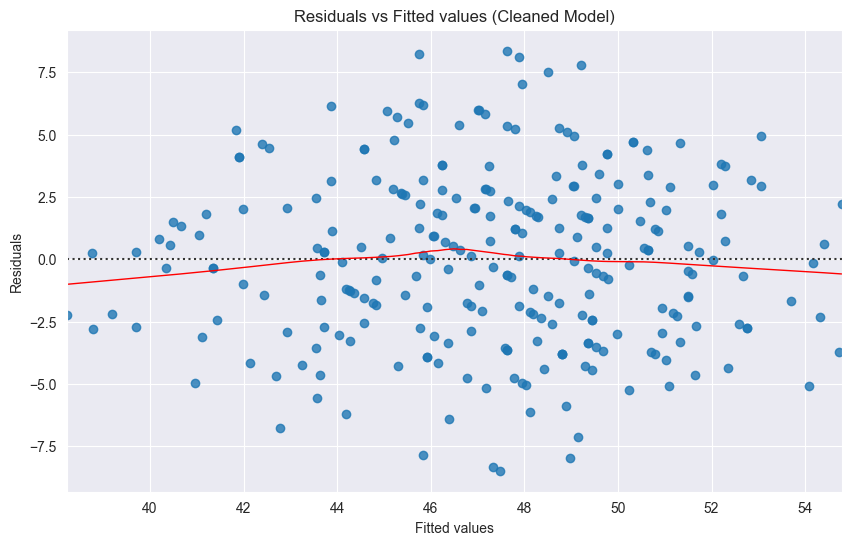

In [98]:
# Plot residuals vs fitted values for the cleaned model
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_cleaned, y=residuals_cleaned, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values (Cleaned Model)')
plt.show()

<Figure size 1000x600 with 0 Axes>

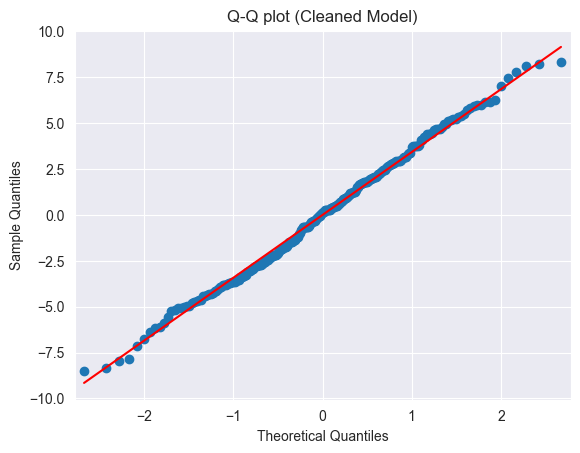

In [99]:
# Q-Q plot for the cleaned model
plt.figure(figsize=(10, 6))
qqplot(residuals_cleaned, line='s')
plt.title('Q-Q plot (Cleaned Model)')
plt.show()

In [100]:
# Durbin-Watson test for the cleaned model
dw_test_cleaned = durbin_watson(residuals_cleaned)

# Breusch-Pagan test for heteroscedasticity for the cleaned model
bp_test_cleaned = het_breuschpagan(residuals_cleaned, model_cleaned.model.exog)

# VIF for multicollinearity for the cleaned model
vif_data_cleaned = calculate_vif(cleaned_data[predictors.columns])

# Log transformation of the dependent variable
data['log_Right_answers'] = np.log(data['Right_answers'])

# Fit a new linear regression model with the log-transformed dependent variable
model_log = smf.ols(formula='log_Right_answers ~ ' + ' + '.join(predictors.columns), data=data).fit()

# Residuals analysis for the log-transformed model
residuals_log = model_log.resid
fitted_log = model_log.fittedvalues

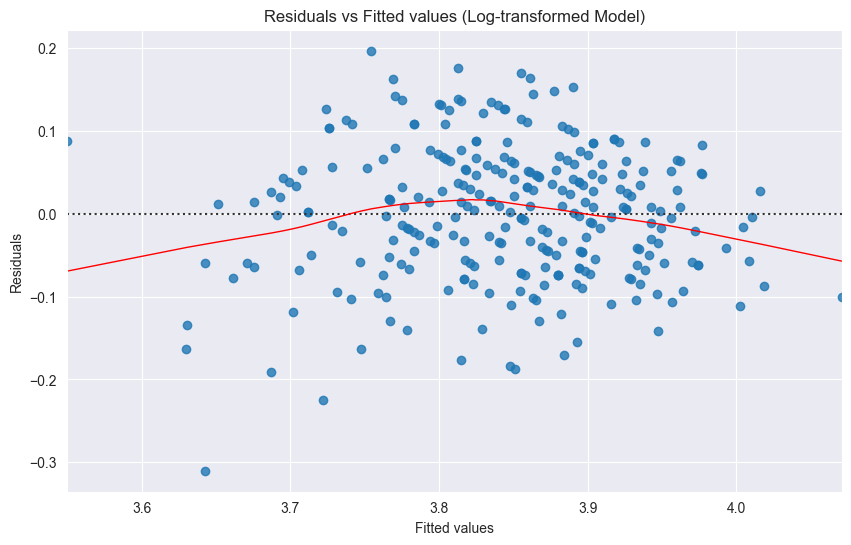

In [101]:
# Plot residuals vs fitted values for the log-transformed model
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_log, y=residuals_log, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values (Log-transformed Model)')
plt.show()

<Figure size 1000x600 with 0 Axes>

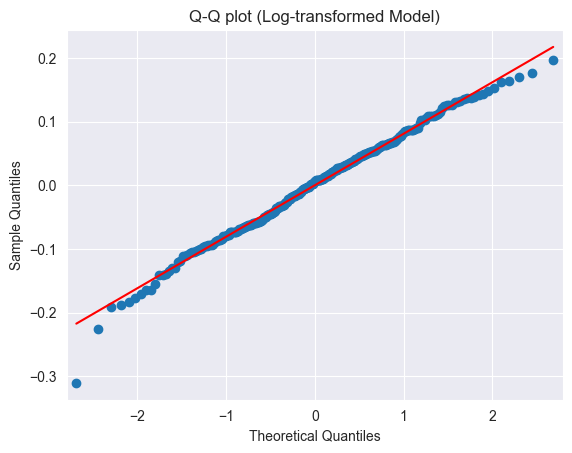

In [102]:
# Q-Q plot for the log-transformed model
plt.figure(figsize=(10, 6))
qqplot(residuals_log, line='s')
plt.title('Q-Q plot (Log-transformed Model)')
plt.show()

In [103]:
# Durbin-Watson test for the log-transformed model
dw_test_log = durbin_watson(residuals_log)

# Breusch-Pagan test for heteroscedasticity for the log-transformed model
bp_test_log = het_breuschpagan(residuals_log, model_log.model.exog)

# VIF for multicollinearity for the log-transformed model
vif_data_log = calculate_vif(data[predictors.columns])

# Display final model summaries and test results
print(model_log.summary())
print(f'Durbin-Watson Test: {dw_test_log}')
print(f'Breusch-Pagan Test: {bp_test_log}')
print(vif_data_log)

                            OLS Regression Results                            
Dep. Variable:      log_Right_answers   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     146.5
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           5.47e-44
Time:                        12:13:49   Log-Likelihood:                 303.74
No. Observations:                 277   AIC:                            -601.5
Df Residuals:                     274   BIC:                            -590.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4962      0.041     85.681      0.0